In [11]:
import os, sys, re, datetime, shutil
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.table import Table
LTE_calc_path = os.path.expanduser('~/Cloud/GitLab/COExcitation/tmp/calc_LTE_R_CI10CO21')

In [12]:
# User-defined global parameters

list_of_X_CICO = np.logspace(np.log10(0.01), np.log10(8.00), num=150, endpoint=True) #<TODO># tune this range
list_of_N_CO = 10**np.arange(17.0, 20.0+0.125, 0.125)
#list_of_T_kin = [25., 25., 25., 50., 50., 100.]
#list_of_d_V_for_T_kin = [3., 15., 30., 60., 60., 60.]
#list_of_T_kin = [15., 25., 30., 50., 50., 300.]
#list_of_d_V_for_T_kin = [4., 10., 30., 50., 50., 90.]
#list_of_CO_abundance_for_T_kin = np.array([3e-4, 3e-4, 3e-4, 3e-4, 3e-4, 3e-4])
#list_of_T_kin = [15., 20., 25., 30., 50., 100.]
#list_of_d_V_for_T_kin = [4., 10., 20., 60., 50., 90.]
#list_of_CO_abundance_for_T_kin = np.array([1e-4, 2e-4, 3e-4, 3e-4, 3e-4, 3e-4])
list_of_T_kin = [15., 20., 25., 30., 50., 300.]
list_of_d_V_for_T_kin = [4., 10., 20., 60., 50., 90.]
list_of_CO_abundance_for_T_kin = np.array([1e-4, 2e-4, 3e-4, 3e-4, 3e-4, 0.5e-4])
list_of_highlight_text_label_for_T_kin = ['Galactic clouds', # Solomon+87,Heyer13
                                          'NGC3627 disk GMCs', 
                                          'NGC3627 bar-ends',
                                          'NGC3627 center',
                                          'NGC1808 starburst ring',
                                          'NGC7469 AGN nucleus']
list_of_highlight_Flux_Kkms_CO10_range_for_T_kin = [
    (30.,50.), (100.,200.), (350.,500.), (1000.,1400.), (800.,1000.), (2000.,2200.) ] # K km s-1

#list_of_highlight_alphaCO_for_T_kin = [4.35/1.36]*len(list_of_highlight_text_label_for_T_kin)
#list_of_highlight_alphaCO_for_T_kin = [np.max([0.3*(t/100.)**(-1.1), 0.6]) for t in list_of_T_kin]
#func_alphaCO = lambda t: np.max([0.3*(t/100.)**(-1.1), 0.5])
#list_of_highlight_alphaCO_for_T_kin = [func_alphaCO(t) for t in list_of_T_kin]
#func_alphaCO = lambda t, abu: \
#                   np.max([0.3*(t/100.)**(-1.1) * (3e-4) / abu, 
#                           0.5]) # see 'calc_LTE_alpha_CO_CI.ipynb'
func_alphaCO = lambda t, abu: \
                    0.15 * (1 + (t/75.)**2.4) * (t/75.)**(-1.2) * \
                    (3e-4) / abu # 20220112, see 'calc_LTE_alpha_CO_CI.ipynb'

list_of_highlight_alphaCO_for_T_kin = np.array([func_alphaCO(t, abu) for t, abu in \
                                                list(zip(list_of_T_kin, list_of_CO_abundance_for_T_kin))])

list_of_highlight_Sigma_H2_range_for_T_kin = [None]*len(list_of_highlight_text_label_for_T_kin)
list_of_highlight_R_CI10CO21_for_T_kin = [0.1, 0.1, 0.1, 0.08, 0.2, 0.5]
list_of_highlight_line_color_for_T_kin = ['magenta', 'blue', 'green', 'lime', 'orange', 'red']

CO_abundance2 = 3e-4 # for another class of Galactic cloud
T_kin2 = 7.5 # for another class of Galactic cloud

out_fig_size = [13., 5.8]

out_fig_margin = dict(left=0.08, right=0.94, bottom=0.10, top=0.83)

overwrite_calc = False # True # False


In [13]:
CO = {}
CO['Einstein_A'] = np.array([
    7.203e-08, 6.910e-07, 2.497e-06, 6.126e-06, 1.221e-05, 2.137e-05, 3.422e-05, 5.134e-05, 7.330e-05, 1.006e-04, 
    1.339e-04, 1.735e-04, 2.200e-04, 2.739e-04, 3.354e-04, 4.050e-04, 4.829e-04, 5.695e-04, 6.650e-04, 7.695e-04, 
    8.833e-04, 1.006e-03, 1.139e-03, 1.281e-03, 1.432e-03, 1.592e-03, 1.761e-03, 1.940e-03, 2.126e-03, 2.321e-03, 
    2.524e-03, 2.735e-03, 2.952e-03, 3.175e-03, 3.404e-03, 3.638e-03, 3.878e-03, 4.120e-03, 4.365e-03, 4.613e-03, 
])
CO['E_u'] = np.array([
    5.53,      16.60,   33.19,   55.32,   82.97,  116.16,  154.87,  199.11,  248.88, 304.16, 
    364.97,   431.29,  503.13,  580.49,  663.35,  751.72,  845.59,  944.97, 1049.84, 1160.20, 
    1276.05, 1397.38, 1524.19, 1656.47, 1794.23, 1937.44, 2086.12, 2240.24, 2399.82, 2564.83, 
    2735.28, 2911.15, 3092.45, 3279.15, 3471.27, 3668.78, 3871.69, 4079.98, 4293.64, 4512.67, 
])
CO['nu'] = np.array([
     115.2712018,  230.5380000,  345.7959899,  461.0407682,  576.2679305, 
     691.4730763,  806.6518060,  921.7997000, 1036.9123930, 1151.9854520, 
    1267.0144860, 1381.9951050, 1496.9229090, 1611.7935180, 1726.6025057, 
    1841.3455060, 1956.0181390, 2070.6159930, 2185.1346800, 2299.5698420, 
    2413.9171130, 2528.1720600, 2642.3303459, 2756.3875840, 2870.3394070, 
    2984.1814550, 3097.9093610, 3211.5187506, 3325.0052827, 3438.3646110, 
    3551.5923610, 3664.6841800, 3777.6357280, 3890.4427170, 4003.1007876, 
    4115.6055850, 4227.9527744, 4340.1381120, 4452.1571221, 4564.0056399, 
])

In [14]:
CI = {}
CI['Einstein_A'] = np.array([
    7.880E-08, 2.650E-07, 
    #1.810E-14, 
])
CI['E_u'] = np.array([
    23.620, 62.462, 
    # 62.462, 
])
CI['nu'] = np.array([
    492.160651, 809.34197, 
    # 1301.50262, 
])

In [15]:
def calc_Q(E_u, T_kin, N=None):
    E_j = np.concatenate([[0.0], E_u])
    if N is None:
        N = len(E_j)
    j = np.arange(N)
    E_j = E_j[0:N]
    #E_j = (j*(j+1)) * E_u[0]
    return np.sum(1.0 * (j+(j+1)) * np.exp(-1.0 * E_j / T_kin))

In [16]:
def calc_Bnu(
        nu, 
        T_ex, 
    ):
    c = const.c.cgs.value # 2.99792458e+10 cm / s
    pi = np.pi
    h = const.h.cgs.value # 6.62607015e-27 erg s
    k = const.k_B.cgs.value # 1.380649e-16 erg / K
    hnu_kt = h*(nu*1e9)/(k*T_ex)
    Bnu = 2*h*(nu*1e9)**3/c**2 * (1.0 / (np.exp(hnu_kt) - 1.0))
    return Bnu

def calc_Bnu_CI10(T_ex):
    global CI
    j_u = 1
    j_l = 0
    idx_trans = 0
    return calc_Bnu(
        nu = CI['nu'][idx_trans], 
        T_ex = T_ex, 
    )

def calc_Bnu_CO21(T_ex):
    global CO
    j_u = 2
    j_l = 1
    idx_trans = 1
    return calc_Bnu(
        nu = CO['nu'][idx_trans], 
        T_ex = T_ex, 
    )

def calc_tau(
        nu, 
        g_u, 
        Q, 
        A_ul, 
        N_dV, 
        T_ex, 
    ):
    c = const.c.cgs.value # 2.99792458e+10 cm / s
    pi = np.pi
    h = const.h.cgs.value # 6.62607015e-27 erg s
    k = const.k_B.cgs.value # 1.380649e-16 erg / K
    hnu_kt = h*(nu*1e9)/(k*T_ex)
    #print('nu', nu)
    #print('Q', Q)
    #print('c**3/(8.0*pi*(nu*1e9)**3)', c**3/(8.0*pi*(nu*1e9)**3))
    #print('hnu_kt', hnu_kt)
    N_dV_cm_2_km_s_1 = N_dV # input should have a unit of cm^{-2} (km s^{-1})^{-1}
    N_dV_cm_2_cm_s_1 = N_dV_cm_2_km_s_1 / 1e5 # km^{-1} to cm^{-1}
    return c**3/(8.0*pi*(nu*1e9)**3) * (g_u/Q) * A_ul * N_dV_cm_2_cm_s_1 / 1.0645 * (1.0 - np.exp( -hnu_kt ))

def calc_tau_CI10(N_dV, T_ex):
    global CI
    j_u = 1
    j_l = 0
    idx_trans = 0
    return calc_tau(
        nu = CI['nu'][idx_trans], 
        g_u = 2*j_u+1, 
        Q = calc_Q(CI['E_u'], T_ex), 
        A_ul = CI['Einstein_A'][idx_trans],
        N_dV = N_dV, 
        T_ex = T_ex, 
    )

def calc_tau_CO21(N_dV, T_ex):
    global CO
    j_u = 2
    j_l = 1
    idx_trans = 1
    return calc_tau(
        nu = CO['nu'][idx_trans], 
        g_u = 2*j_u+1, 
        Q = calc_Q(CO['E_u'], T_ex), 
        A_ul = CO['Einstein_A'][idx_trans],
        N_dV = N_dV, 
        T_ex = T_ex, 
    )


In [17]:
def calc_LTE_R_CI10CO21(
        N_CO, 
        d_V, 
        T_kin, 
        T_CMB = 2.73, 
        verbose = True,
        overwrite = False, 
    ):
    #
    global list_of_X_CICO
    global LTE_calc_path
    global CO
    global CI
    #
    list_of_R_CI10CO21 = np.zeros(len(list_of_X_CICO))
    N_CO_str = '{:.2e}'.format(N_CO).replace('e+','e')
    d_V_str = '{:.0f}'.format(d_V)
    T_kin_str = '{:.0f}'.format(T_kin)
    out_table_dict = {'N_CO': [], 'N_CI': [], 'X_CICO': [], 'line_width': [], 'T_kin': [], 
                      'tau_CI10': [], 'tau_CO21': [], 'omexpm_tau_CI10': [], 'omexpm_tau_CO21': [], 
                      'R_CI10CO21': []}
    out_table_name = f'out_table_LTE_R_CI10CO21_N_CO_{N_CO_str}_dV_{d_V_str}_T_kin_{T_kin_str}.csv'
    out_table_file = os.path.join(LTE_calc_path, out_table_name)
    if not os.path.isdir(LTE_calc_path):
        os.makedirs(LTE_calc_path)
    if not os.path.isdir(LTE_calc_path):
        raise Exception('Error! Could not create dir: ' + LTE_calc_path)
    
    if os.path.isfile(out_table_file) and not overwrite:
        print(f'Found "{out_table_file}". Returning.')
        return
    
    nu_CI10 = CI['nu'][0]
    nu_CO21 = CO['nu'][1]
    for i in range(len(list_of_X_CICO)):
        X_CICO = list_of_X_CICO[i]

        tau_CI10 = calc_tau_CI10(N_dV = X_CICO*N_CO/d_V, T_ex = T_kin)
        tau_CO21 = calc_tau_CO21(N_dV = N_CO/d_V, T_ex = T_kin)

        omexpm_tau_CI10 = 1.0 - np.exp(-tau_CI10)
        omexpm_tau_CO21 = 1.0 - np.exp(-tau_CO21)
        R_ometau_CI10CO21 = omexpm_tau_CI10 / omexpm_tau_CO21
        
        Bnu_CI10 = calc_Bnu_CI10(T_ex = T_kin)
        Bnu_CO21 = calc_Bnu_CO21(T_ex = T_kin)
        Bnu_TCMB_CI10 = calc_Bnu_CI10(T_ex = T_CMB)
        Bnu_TCMB_CO21 = calc_Bnu_CO21(T_ex = T_CMB)
        
        R_Bnu_CI10CO21 = (Bnu_CI10 - Bnu_TCMB_CI10) / (Bnu_CO21 - Bnu_TCMB_CO21)
        
        R_CI10CO21 = nu_CI10**(-2) / nu_CO21**(-2) * R_ometau_CI10CO21 * R_Bnu_CI10CO21
        
        list_of_R_CI10CO21[i] = R_CI10CO21
    
        if verbose:
            print('i', i+1, '/', len(list_of_X_CICO))
            print('tau_CI10', tau_CI10)
            print('tau_CO21', tau_CO21)
            print('1-e^-tau_CI10', omexpm_tau_CI10)
            print('1-e^-tau_CO21', omexpm_tau_CO21)
            print('(1-e^-tau_CI10)/(1-e^-tau_CO21)', R_ometau_CI10CO21)
            print('Bnu(CI10)', Bnu_CI10)
            print('Bnu(CO21)', Bnu_CO21)
            print('(Bnu(CI10)-Bnu(TCMB))/(Bnu(CO21)-Bnu(TCMB))', R_Bnu_CI10CO21)
            print('R_CI10CO21', R_CI10CO21)

        out_table_dict['N_CO'].append(N_CO)
        out_table_dict['N_CI'].append(X_CICO*N_CO)
        out_table_dict['X_CICO'].append(X_CICO)
        out_table_dict['line_width'].append(d_V)
        out_table_dict['T_kin'].append(T_kin)
        out_table_dict['tau_CI10'].append(tau_CI10)
        out_table_dict['tau_CO21'].append(tau_CO21)
        out_table_dict['omexpm_tau_CI10'].append(omexpm_tau_CI10)
        out_table_dict['omexpm_tau_CO21'].append(omexpm_tau_CO21)
        out_table_dict['R_CI10CO21'].append(R_CI10CO21)

    out_table = Table(out_table_dict)
    out_table.write(out_table_file, format='csv', overwrite=overwrite)
    print(f'Output to "{out_table_file}"')
    
    
    
# Call the function for a list of N_CO and T_kin
verbose = True
for N_CO in list_of_N_CO:
    for idx_T_kin, T_kin in enumerate(list_of_T_kin):
        calc_LTE_R_CI10CO21(
            N_CO = N_CO,
            d_V = list_of_d_V_for_T_kin[idx_T_kin],
            T_kin = T_kin,
            verbose = verbose,
            overwrite = overwrite_calc, 
        )
        verbose = False # first iteration is verbose, others are non-verbose.


i 1 / 150
tau_CI10 0.002330210061710214
tau_CO21 6.420798404226728
1-e^-tau_CI10 0.0023274972298095165
1-e^-tau_CO21 0.9983726435722787
(1-e^-tau_CI10)/(1-e^-tau_CO21) 0.0023312910713193173
Bnu(CI10) 4.590558222419742e-13
Bnu(CO21) 1.6560687358500043e-13
(Bnu(CI10)-Bnu(TCMB))/(Bnu(CO21)-Bnu(TCMB)) 2.8245889318798474
R_CI10CO21 0.0014448508548763866
i 2 / 150
tau_CI10 0.002437131138665776
tau_CO21 6.420798404226728
1-e^-tau_CI10 0.00243416374570371
1-e^-tau_CO21 0.9983726435722787
(1-e^-tau_CI10)/(1-e^-tau_CO21) 0.0024381314545979796
Bnu(CI10) 4.590558222419742e-13
Bnu(CO21) 1.6560687358500043e-13
(Bnu(CI10)-Bnu(TCMB))/(Bnu(CO21)-Bnu(TCMB)) 2.8245889318798474
R_CI10CO21 0.0015110667045463877
i 3 / 150
tau_CI10 0.0025489582611685534
tau_CO21 6.420798404226728
1-e^-tau_CI10 0.002545712425478852
1-e^-tau_CO21 0.9983726435722787
(1-e^-tau_CI10)/(1-e^-tau_CO21) 0.0025498619597288186
Bnu(CI10) 4.590558222419742e-13
Bnu(CO21) 1.6560687358500043e-13
(Bnu(CI10)-Bnu(TCMB))/(Bnu(CO21)-Bnu(TCMB)) 2

Bnu(CI10) 4.590558222419742e-13
Bnu(CO21) 1.6560687358500043e-13
(Bnu(CI10)-Bnu(TCMB))/(Bnu(CO21)-Bnu(TCMB)) 2.8245889318798474
R_CI10CO21 0.016097658754383095
i 56 / 150
tau_CI10 0.02747928770187789
tau_CO21 6.420798404226728
1-e^-tau_CI10 0.027105166767402822
1-e^-tau_CO21 0.9983726435722787
(1-e^-tau_CI10)/(1-e^-tau_CO21) 0.027149348434085476
Bnu(CI10) 4.590558222419742e-13
Bnu(CO21) 1.6560687358500043e-13
(Bnu(CI10)-Bnu(TCMB))/(Bnu(CO21)-Bnu(TCMB)) 2.8245889318798474
R_CI10CO21 0.016826195483229042
i 57 / 150
tau_CI10 0.028740167604224594
tau_CO21 6.420798404226728
1-e^-tau_CI10 0.028331097271738215
1-e^-tau_CO21 0.9983726435722787
(1-e^-tau_CI10)/(1-e^-tau_CO21) 0.028377277216217255
Bnu(CI10) 4.590558222419742e-13
Bnu(CO21) 1.6560687358500043e-13
(Bnu(CI10)-Bnu(TCMB))/(Bnu(CO21)-Bnu(TCMB)) 2.8245889318798474
R_CI10CO21 0.017587221840004982
i 58 / 150
tau_CI10 0.03005890264988469
tau_CO21 6.420798404226728
1-e^-tau_CI10 0.029611626581528494
1-e^-tau_CO21 0.9983726435722787
(1-e^-ta

i 101 / 150
tau_CI10 0.20690815817675168
tau_CO21 6.420798404226728
1-e^-tau_CI10 0.18690567737645436
1-e^-tau_CO21 0.9983726435722787
(1-e^-tau_CI10)/(1-e^-tau_CO21) 0.18721033531897155
Bnu(CI10) 4.590558222419742e-13
Bnu(CO21) 1.6560687358500043e-13
(Bnu(CI10)-Bnu(TCMB))/(Bnu(CO21)-Bnu(TCMB)) 2.8245889318798474
R_CI10CO21 0.11602627246122277
i 102 / 150
tau_CI10 0.21640208469722735
tau_CO21 6.420798404226728
1-e^-tau_CI10 0.19458860683768753
1-e^-tau_CO21 0.9983726435722787
(1-e^-tau_CI10)/(1-e^-tau_CO21) 0.1949057880246295
Bnu(CI10) 4.590558222419742e-13
Bnu(CO21) 1.6560687358500043e-13
(Bnu(CI10)-Bnu(TCMB))/(Bnu(CO21)-Bnu(TCMB)) 2.8245889318798474
R_CI10CO21 0.12079563891109228
i 103 / 150
tau_CI10 0.22633163754375238
tau_CO21 6.420798404226728
1-e^-tau_CI10 0.20254640774311927
1-e^-tau_CO21 0.9983726435722787
(1-e^-tau_CI10)/(1-e^-tau_CO21) 0.2028765602174231
Bnu(CI10) 4.590558222419742e-13
Bnu(CO21) 1.6560687358500043e-13
(Bnu(CI10)-Bnu(TCMB))/(Bnu(CO21)-Bnu(TCMB)) 2.824588931879

1-e^-tau_CO21 0.9983726435722787
(1-e^-tau_CI10)/(1-e^-tau_CO21) 0.790716647860007
Bnu(CI10) 4.590558222419742e-13
Bnu(CO21) 1.6560687358500043e-13
(Bnu(CI10)-Bnu(TCMB))/(Bnu(CO21)-Bnu(TCMB)) 2.8245889318798474
R_CI10CO21 0.49005790768931307
i 147 / 150
tau_CI10 1.629422030733819
tau_CO21 6.420798404226728
1-e^-tau_CI10 0.8039571518696162
1-e^-tau_CO21 0.9983726435722787
(1-e^-tau_CI10)/(1-e^-tau_CO21) 0.8052676092896295
Bnu(CI10) 4.590558222419742e-13
Bnu(CO21) 1.6560687358500043e-13
(Bnu(CI10)-Bnu(TCMB))/(Bnu(CO21)-Bnu(TCMB)) 2.8245889318798474
R_CI10CO21 0.49907607333988785
i 148 / 150
tau_CI10 1.70418763285868
tau_CO21 6.420798404226728
1-e^-tau_CI10 0.8180798879151912
1-e^-tau_CO21 0.9983726435722787
(1-e^-tau_CI10)/(1-e^-tau_CO21) 0.819413365522535
Bnu(CI10) 4.590558222419742e-13
Bnu(CO21) 1.6560687358500043e-13
(Bnu(CI10)-Bnu(TCMB))/(Bnu(CO21)-Bnu(TCMB)) 2.8245889318798474
R_CI10CO21 0.5078431072969217
i 149 / 150
tau_CI10 1.7823838350096002
tau_CO21 6.420798404226728
1-e^-tau_C

Output to "/Users/dzliu/Cloud/GitLab/COExcitation/tmp/calc_LTE_R_CI10CO21/out_table_LTE_R_CI10CO21_N_CO_1.00e18_dV_60_T_kin_30.csv"
Output to "/Users/dzliu/Cloud/GitLab/COExcitation/tmp/calc_LTE_R_CI10CO21/out_table_LTE_R_CI10CO21_N_CO_1.00e18_dV_50_T_kin_50.csv"
Output to "/Users/dzliu/Cloud/GitLab/COExcitation/tmp/calc_LTE_R_CI10CO21/out_table_LTE_R_CI10CO21_N_CO_1.00e18_dV_90_T_kin_300.csv"
Output to "/Users/dzliu/Cloud/GitLab/COExcitation/tmp/calc_LTE_R_CI10CO21/out_table_LTE_R_CI10CO21_N_CO_1.33e18_dV_4_T_kin_15.csv"
Output to "/Users/dzliu/Cloud/GitLab/COExcitation/tmp/calc_LTE_R_CI10CO21/out_table_LTE_R_CI10CO21_N_CO_1.33e18_dV_10_T_kin_20.csv"
Output to "/Users/dzliu/Cloud/GitLab/COExcitation/tmp/calc_LTE_R_CI10CO21/out_table_LTE_R_CI10CO21_N_CO_1.33e18_dV_20_T_kin_25.csv"
Output to "/Users/dzliu/Cloud/GitLab/COExcitation/tmp/calc_LTE_R_CI10CO21/out_table_LTE_R_CI10CO21_N_CO_1.33e18_dV_60_T_kin_30.csv"
Output to "/Users/dzliu/Cloud/GitLab/COExcitation/tmp/calc_LTE_R_CI10CO21/ou

Output to "/Users/dzliu/Cloud/GitLab/COExcitation/tmp/calc_LTE_R_CI10CO21/out_table_LTE_R_CI10CO21_N_CO_2.37e19_dV_10_T_kin_20.csv"
Output to "/Users/dzliu/Cloud/GitLab/COExcitation/tmp/calc_LTE_R_CI10CO21/out_table_LTE_R_CI10CO21_N_CO_2.37e19_dV_20_T_kin_25.csv"
Output to "/Users/dzliu/Cloud/GitLab/COExcitation/tmp/calc_LTE_R_CI10CO21/out_table_LTE_R_CI10CO21_N_CO_2.37e19_dV_60_T_kin_30.csv"
Output to "/Users/dzliu/Cloud/GitLab/COExcitation/tmp/calc_LTE_R_CI10CO21/out_table_LTE_R_CI10CO21_N_CO_2.37e19_dV_50_T_kin_50.csv"
Output to "/Users/dzliu/Cloud/GitLab/COExcitation/tmp/calc_LTE_R_CI10CO21/out_table_LTE_R_CI10CO21_N_CO_2.37e19_dV_90_T_kin_300.csv"
Output to "/Users/dzliu/Cloud/GitLab/COExcitation/tmp/calc_LTE_R_CI10CO21/out_table_LTE_R_CI10CO21_N_CO_3.16e19_dV_4_T_kin_15.csv"
Output to "/Users/dzliu/Cloud/GitLab/COExcitation/tmp/calc_LTE_R_CI10CO21/out_table_LTE_R_CI10CO21_N_CO_3.16e19_dV_10_T_kin_20.csv"
Output to "/Users/dzliu/Cloud/GitLab/COExcitation/tmp/calc_LTE_R_CI10CO21/ou

In [18]:
# Define function to read x y from table

def read_X_CICO_R_CICO_from_table(
        N_CO, 
        d_V, 
        T_kin, 
        n_H2 = None, 
        LTE = True,
    ):
    N_CO_str = '{:.2e}'.format(N_CO).replace('e+','e')
    d_V_str = '{:.0f}'.format(d_V)
    T_kin_str = '{:.0f}'.format(T_kin)
    in_table_name = f'out_table_LTE_R_CI10CO21_N_CO_{N_CO_str}_dV_{d_V_str}_T_kin_{T_kin_str}.csv'
    in_table_file = os.path.join(LTE_calc_path, in_table_name)
    in_table = Table.read(in_table_file, format='csv')
    
    x = in_table['X_CICO']
    y = in_table['R_CI10CO21']
    mask_CO_opt_thin = in_table['tau_CO21']<1.
    mask_CI_opt_thin = in_table['tau_CI10']<1.
    
    return x, y, mask_CO_opt_thin, mask_CI_opt_thin


panel 1
CO_abundance 0.0001
highlight_R_CI10CO21 0.1
highlight_Flux_Kkms_CO10_range (30.0, 50.0)
highlight_alphaCO 3.1696219080187253
highlight_Sigma_H2_range (95.08865724056176, 158.48109540093625) vs. right axis y range (16.0141791, 16014.1791)
highlight_N_CO_range [5.93777905e+17 9.89629842e+17]
highlight_N_CO_range in log10 [17.77362403 17.99547278]
highlight_N_CO_mean 7.917038739797097e+17 vs. left axis y range [1.e+17 1.e+20]
highlight_line_color (0.0, 0.15664961636828614, 1.0, 1.0)
highlight_R_CI10CO21_min_max_in_Sigma_H2_range (0.008764120128546717, 0.6197642139377606)
highlight_X_CICO_range (0.09, 0.117)
CO_abundance2 0.0003
highlight_alphaCO2 2.3868041488588734
highlight_Sigma_H2_range2 (71.6041244657662, 119.34020744294367)
highlight_N_CO_range2 [1.34138860e+18 2.23564767e+18]
highlight_N_CO_range2 in log10 [18.12755461 18.34940336]
highlight_N_CO_mean2 1.7885181380484547e+18
highlight_R_CI10CO21_min_max_in_Sigma_H2_range2 (0.019397380238188603, 0.6197642467951114)
highlight

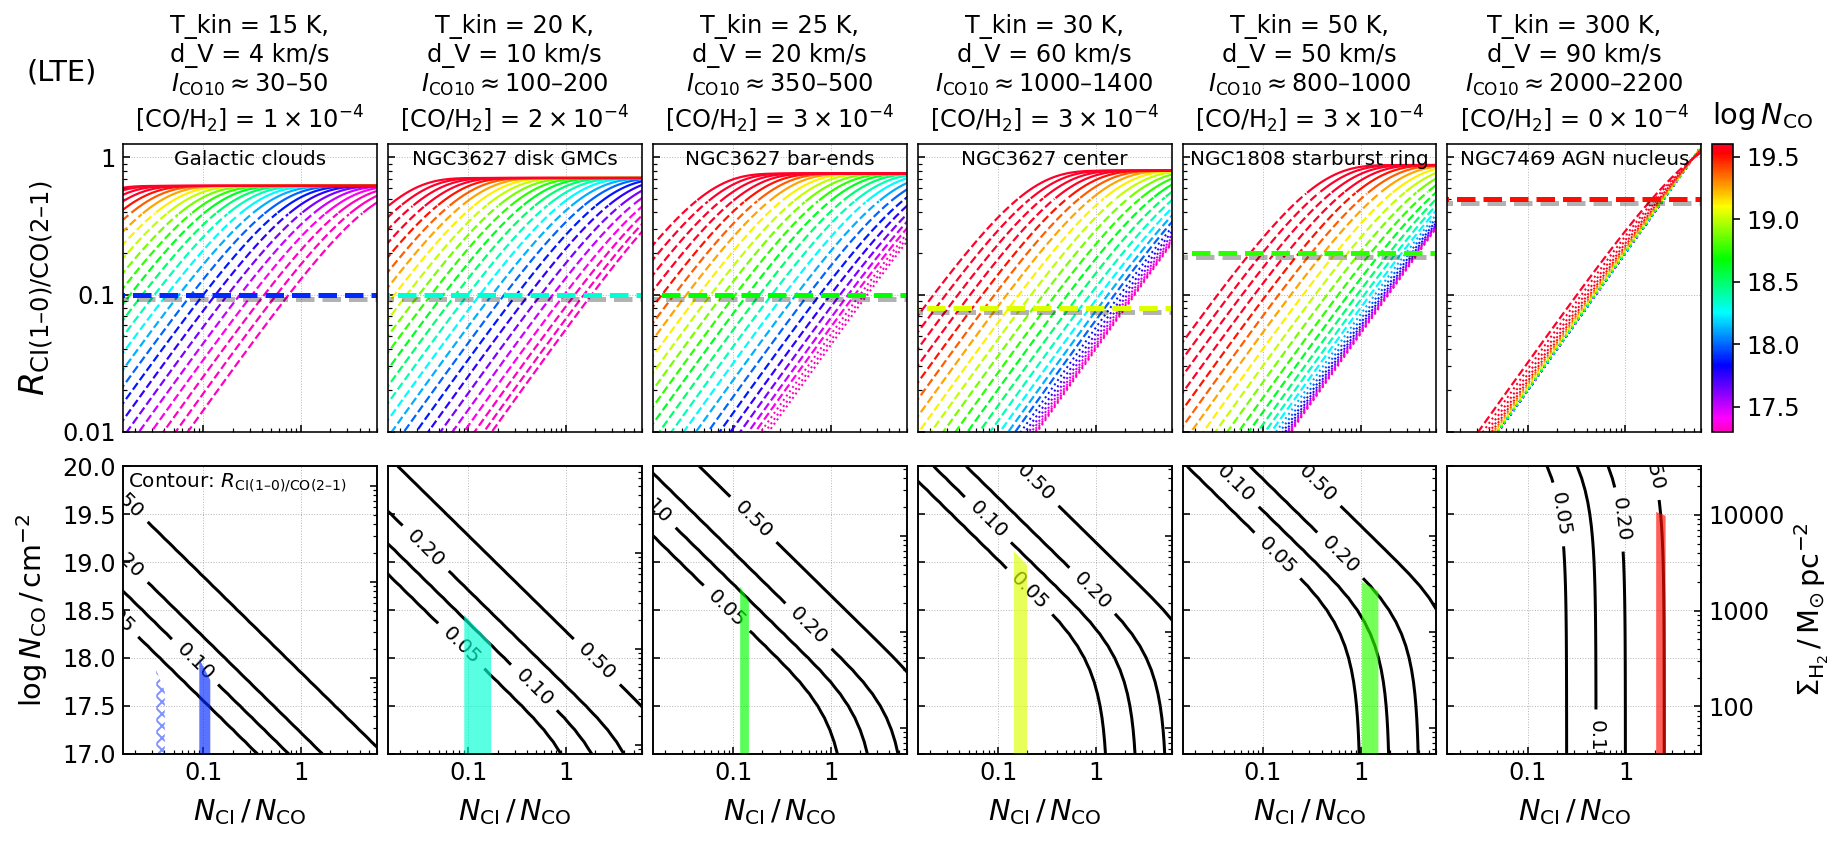

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import ticker
import matplotlib.patheffects as path_effects


def make_a_figure(
        out_figure_file, 
        n_H2 = None, 
        LTE = True, 
    ):
    # 
    global list_of_X_CICO
    global list_of_N_CO
    global list_of_T_kin
    global list_of_d_V_for_T_kin
    # 
    minima = np.nan
    maxima = np.nan
    fig = plt.figure(figsize=out_fig_size)
    gs = gridspec.GridSpec(ncols=len(list_of_T_kin)+1, nrows=2, 
                           figure=fig, width_ratios=[1]*len(list_of_T_kin)+[0.08], 
                           wspace=0.05, hspace=0.12)
    upper_axes = []
    for i in range(len(list_of_T_kin)):
        ax = fig.add_subplot(gs[0, i])
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim([0.01, 1.25])
        #ax.set_xlim([0.04, 3.00])
        #ax.set_xlim([0.015, 3.00])
        ax.set_xlim([0.015, 6.00])
        ax.grid(True, c='#999999', lw=0.5, ls='dotted', alpha=0.7)
        upper_axes.append(ax)
    lower_axes = []
    for i in range(len(list_of_T_kin)):
        lower_axes.append(fig.add_subplot(gs[1, i]))
    fig.subplots_adjust(**out_fig_margin)
    lower_right_axes = []
    norm = matplotlib.colors.Normalize(vmin=np.min(np.log10(list_of_N_CO))+0.3, 
                                       vmax=np.max(np.log10(list_of_N_CO))-0.4, clip=True)
    cmap = cm.gist_rainbow_r
    colormapper = cm.ScalarMappable(norm=norm, cmap=cmap)

    # out_figure_file = 'Plot_LTE_RCI10CO21_vs_XCICO_varying_N_CO_T_kin.pdf'


    for idx_T_kin, T_kin in enumerate(list_of_T_kin):

        x_array_for_contour = []
        y_array_for_contour = []
        data_array_for_contour = []

        icol = idx_T_kin

        d_V = list_of_d_V_for_T_kin[idx_T_kin]
        d_V_str = '{:.0f}'.format(d_V)
        T_kin_str = '{:.0f}'.format(T_kin)
        I_CO_str = '{:g}–{:g}'.format(*list_of_highlight_Flux_Kkms_CO10_range_for_T_kin[idx_T_kin])
        CO_abundance = list_of_CO_abundance_for_T_kin[idx_T_kin]
        CO_abundance_str = r'${:.0f} \times 10^{{-4}}$'.format(
                               list_of_CO_abundance_for_T_kin[idx_T_kin]/1e-4
                           )
        panel_title_str = f'T_kin = {T_kin_str} K,' + '\n' + \
                          f'd_V = {d_V_str} km/s' + '\n' + \
                          r'$I_{\mathrm{CO10}} \approx $' + f'{I_CO_str}' + '\n' + \
                          f'$\mathrm{{[CO/H_2]}}$ = {CO_abundance_str}'
                          # panel title
        ax = upper_axes[icol]
        ax.set_title(panel_title_str, fontsize='large', pad=8)
        if icol == 0:
            ax.set_ylabel(r'$R_{\mathrm{CI(1–0)/CO(2–1)}}$', fontsize='xx-large', labelpad=3)
        if icol != 0:
            ax.yaxis.set_major_formatter(ticker.NullFormatter()) # hide y ticks in the non-first-column panel
        ax.xaxis.set_major_formatter(ticker.NullFormatter()) # hide y ticks in the upper panels
        ax.tick_params(which='both', direction='in', labelsize='large')

        # top left text label
        highlight_text_label = list_of_highlight_text_label_for_T_kin[idx_T_kin]
        ax.text(0.5, 0.98, highlight_text_label, ha='center', va='top', transform=ax.transAxes)

        for i_N_CO, N_CO in enumerate(list_of_N_CO):
            
            # read X_CICO, R_CICO, and optical depth masks for each (T_kin, N_CO) grid
            x, y, mask_CO_opt_thin, mask_CI_opt_thin = read_X_CICO_R_CICO_from_table(
                N_CO=N_CO, d_V=d_V, T_kin=T_kin, n_H2=n_H2, LTE=LTE)

            # plot R_CI10CO21 versus X_CICO curves in the upper panel
            mask = np.logical_and(mask_CO_opt_thin, mask_CI_opt_thin)
            if np.count_nonzero(mask) > 0:
                ax.plot(x[mask], y[mask], color=colormapper.to_rgba(np.log10(N_CO)), 
                        lw=1.0, ls='dotted', alpha=1.0)

            mask = np.logical_and(~mask_CO_opt_thin, mask_CI_opt_thin)
            if np.count_nonzero(mask) > 0:
                ax.plot(x[mask], y[mask], color=colormapper.to_rgba(np.log10(N_CO)), 
                        lw=1.1, ls='dashed', alpha=1.0)

            mask = np.logical_and(~mask_CO_opt_thin, ~mask_CI_opt_thin)
            if np.count_nonzero(mask) > 0:
                ax.plot(x[mask], y[mask], color=colormapper.to_rgba(np.log10(N_CO)), 
                        lw=1.1, ls='solid', alpha=1.0)

            # compute global extrema
            miny = np.min(y)
            maxy = np.max(y)
            if np.isnan(minima) or minima > miny:
                minima = miny
            if np.isnan(maxima) or maxima < maxy:
                maxima = maxy

            # prepare data array for contour
            if len(x_array_for_contour) == 0:
                x_array_for_contour = x # X_CICO
            y_array_for_contour.append(np.log10(N_CO))
            data_array_for_contour.append(y) # R_CI10CO21

        # plot contour in the lower panel
        x = np.array(x_array_for_contour)
        y = np.array(y_array_for_contour)
        data_array_for_contour = np.array(data_array_for_contour)
        ax = lower_axes[icol]
        ax.tick_params(which='both', direction='in', labelsize='large')
        cs = ax.contour(x, y, data_array_for_contour, 
                        levels=[0.05, 0.1, 0.2, 0.5], colors='k') # show R_CICO = 0.05, 0.1 and 0.2 contours
        ax.set_xlabel(r'$N_{\mathrm{CI}} \, / \, N_{\mathrm{CO}}$', fontsize='x-large', labelpad=6)
        ax.set_xscale('log')
        #ax.set_xlim([0.04, 3.00])
        #ax.set_xlim([0.015, 3.00])
        ax.set_xlim([0.015, 6.00])
        ax.set_ylim([ax.get_ylim()[0], ax.get_ylim()[1]])
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
        axRight = ax.twinx()
        axRight.set_yscale('log')
        axRight.set_ylim(10**np.array(ax.get_ylim()) / CO_abundance * 1.60141791e-20) 
        # (const.m_p+const.m_p-const.m_e) * ((1.*u.pc).to(u.cm).value)**2 / const.M_sun = 1.60141791e-20, 
        # [CO/H2] = 3e-4
        axRight.tick_params(which='both', direction='in', labelsize='large')
        if icol == 0:
            ax.set_ylabel(r'$\log N_{\mathrm{CO}} \, / \, \mathrm{cm^{-2}}$', 
                          fontsize='x-large', labelpad=6) # show y axis title in the last column panel
            axRight.yaxis.set_major_formatter(ticker.NullFormatter()) # hide right y major tick labels
            axRight.yaxis.set_minor_formatter(ticker.NullFormatter()) # hide right y minor tick labels
        elif icol == len(list_of_T_kin)-1:
            axRight.set_ylabel(r'$\Sigma_{\mathrm{H_2}} \, / \, \mathrm{M_{\odot} \, pc^{-2}}$', 
                               fontsize='x-large', labelpad=4) # show right y axis title in the last column panel
            axRight.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g')) # show right y axis tick labels
            axRight.tick_params(axis='y', labelsize='large')
            ax.yaxis.set_major_formatter(ticker.NullFormatter()) # hide y ticks at left
        else:
            ax.yaxis.set_major_formatter(
                ticker.NullFormatter()) # hide y ticks in the non-last-column panel
            axRight.yaxis.set_major_formatter(
                ticker.NullFormatter()) # hide right y major tick labels in the non-last-column panel
            axRight.yaxis.set_minor_formatter(
                ticker.NullFormatter()) # hide right y minor tick labels in the non-last-column panel
        ax.clabel(cs, cs.levels, inline=True)
        ax.grid(True, c='#999999', lw=0.5, ls='dotted', alpha=0.7)
        lower_right_axes.append(axRight)

        # plot highlight shading in the lower panels
        highlight_text_label = list_of_highlight_text_label_for_T_kin[idx_T_kin]
        highlight_line_color = list_of_highlight_line_color_for_T_kin[idx_T_kin]
        highlight_Flux_Kkms_CO10_range = list_of_highlight_Flux_Kkms_CO10_range_for_T_kin[idx_T_kin]
        highlight_Sigma_H2_range = list_of_highlight_Sigma_H2_range_for_T_kin[idx_T_kin]
        highlight_R_CI10CO21 = list_of_highlight_R_CI10CO21_for_T_kin[idx_T_kin]
        highlight_alphaCO = list_of_highlight_alphaCO_for_T_kin[idx_T_kin]
        if highlight_text_label is not None and highlight_text_label != '':
            from scipy.interpolate import interp2d
            func_interp = interp2d(x, y, data_array_for_contour)
            x_interp = np.linspace(np.min(x), np.max(x), num=300, endpoint=True)
            y_interp = np.linspace(np.min(y), np.max(y), num=300, endpoint=True)
            data_array_interp = func_interp(x_interp, y_interp)
            x_grid, y_grid = np.meshgrid(x_interp, y_interp)
            # 
            #highlight_val = highlight_R_CI10CO21
            if highlight_Sigma_H2_range is None:
                highlight_Sigma_H2_range = (\
                    highlight_Flux_Kkms_CO10_range[0] * highlight_alphaCO, 
                    # convert CO flux in units of K km s-1 to H2 surface density in M_sun pc^-2, no helium.
                    highlight_Flux_Kkms_CO10_range[1] * highlight_alphaCO, 
                    # convert CO flux in units of K km s-1 to H2 surface density in M_sun pc^-2, no helium.
                )
            highlight_N_CO_range = np.array(highlight_Sigma_H2_range) * CO_abundance / 1.60141791e-20 # cm^-2
            highlight_N_CO_mean = np.mean(highlight_N_CO_range)
            highlight_line_color = colormapper.to_rgba(np.log10(highlight_N_CO_mean))
            print('panel', idx_T_kin+1)
            print('CO_abundance', CO_abundance)
            print('highlight_R_CI10CO21', highlight_R_CI10CO21)
            print('highlight_Flux_Kkms_CO10_range', highlight_Flux_Kkms_CO10_range)
            print('highlight_alphaCO', highlight_alphaCO)
            print('highlight_Sigma_H2_range', highlight_Sigma_H2_range, 
                  'vs. right axis y range', axRight.get_ylim())
            print('highlight_N_CO_range', highlight_N_CO_range)
            print('highlight_N_CO_range in log10', np.log10(highlight_N_CO_range))
            print('highlight_N_CO_mean', highlight_N_CO_mean, 
                  'vs. left axis y range', 10**np.array(ax.get_ylim()))
            print('highlight_line_color', highlight_line_color)
            highlight_ymin, highlight_ymax = highlight_Sigma_H2_range
            highlight_ymask = np.logical_and(
                                10**y_grid > highlight_ymin * CO_abundance / 1.60141791e-20, 
                                10**y_grid < highlight_ymax * CO_abundance / 1.60141791e-20, 
                            )
            if np.count_nonzero(highlight_ymask) > 0:
                highlight_valmin = np.min(data_array_interp[highlight_ymask])
                highlight_valmax = np.max(data_array_interp[highlight_ymask])
                print('highlight_R_CI10CO21_min_max_in_Sigma_H2_range', 
                      (highlight_valmin, highlight_valmax))
                if (highlight_R_CI10CO21 >= highlight_valmin) and \
                   (highlight_R_CI10CO21 <= highlight_valmax):
                    highlight_mask = np.logical_and(
                                        np.isclose(data_array_interp, highlight_R_CI10CO21, 
                                                   rtol=0.10, atol=0.0), # within 10% of highlight_val
                                        highlight_ymask, 
                                    )
                    if np.count_nonzero(highlight_mask) > 0:
                        highlight_xmin = np.min(x_grid[highlight_mask])
                        highlight_xmax = np.max(x_grid[highlight_mask])
                        highlight_X_CICO_range = (np.round(highlight_xmin, 3), np.round(highlight_xmax, 3))
                        print('highlight_X_CICO_range', highlight_X_CICO_range)
                        if highlight_xmin == highlight_xmax:
                            highlight_xwidth = 0.10 #<TODO># tune this width if matched to a single element
                            highlight_xcen = (highlight_xmin + highlight_xmax) / 2.
                            highlight_xmin = highlight_xcen * (1.0 - highlight_xwidth)
                            highlight_xmax = highlight_xcen * (1.0 + highlight_xwidth)
                        lower_right_axes[-1].fill_between([highlight_xmin, highlight_xmax], 
                                                          [axRight.get_ylim()[0]]*2, 
                                                          np.array([highlight_ymax, highlight_ymin]), 
                                                          color=highlight_line_color, 
                                                          alpha=0.65, 
                                                          lw=0)
                    else:
                        print('no possible highlight range in contour xy!')
                else:
                    print('no possible highlight range in contour!')
            else:
                print('no possible highlight range in y!')
            # 
            # 20220105: highlighting 'Galactic clouds' with another T_kin and CO abundance
            if highlight_text_label == 'Galactic clouds':
                print('CO_abundance2', CO_abundance2)
                highlight_alphaCO2 = func_alphaCO(T_kin2, CO_abundance2)
                highlight_Sigma_H2_range2 = (\
                    highlight_Flux_Kkms_CO10_range[0] * highlight_alphaCO2, 
                    # convert CO flux in units of K km s-1 to H2 surface density in M_sun pc^-2, no helium.
                    highlight_Flux_Kkms_CO10_range[1] * highlight_alphaCO2, 
                    # convert CO flux in units of K km s-1 to H2 surface density in M_sun pc^-2, no helium.
                )
                highlight_N_CO_range2 = np.array(highlight_Sigma_H2_range2) * \
                                        CO_abundance2 / 1.60141791e-20 # cm^-2
                highlight_N_CO_mean2 = np.mean(highlight_N_CO_range2)
                highlight_line_color2 = colormapper.to_rgba(np.log10(highlight_N_CO_mean2))
                # 
                print('highlight_alphaCO2', highlight_alphaCO2)
                print('highlight_Sigma_H2_range2', highlight_Sigma_H2_range2)
                print('highlight_N_CO_range2', highlight_N_CO_range2)
                print('highlight_N_CO_range2 in log10', np.log10(highlight_N_CO_range2))
                print('highlight_N_CO_mean2', np.mean(highlight_N_CO_mean2))
                # 
                highlight_ymin, highlight_ymax = highlight_Sigma_H2_range2
                highlight_ymask = np.logical_and(
                                    10**y_grid > highlight_ymin * CO_abundance2 / 1.60141791e-20, 
                                    10**y_grid < highlight_ymax * CO_abundance2 / 1.60141791e-20, 
                                )
                if np.count_nonzero(highlight_ymask) > 0:
                    highlight_valmin = np.min(data_array_interp[highlight_ymask])
                    highlight_valmax = np.max(data_array_interp[highlight_ymask])
                    print('highlight_R_CI10CO21_min_max_in_Sigma_H2_range2', 
                          (highlight_valmin, highlight_valmax))
                    if (highlight_R_CI10CO21 >= highlight_valmin) and \
                       (highlight_R_CI10CO21 <= highlight_valmax):
                        highlight_mask = np.logical_and(
                                            np.isclose(data_array_interp, highlight_R_CI10CO21, 
                                                       rtol=0.10, atol=0.0), # within 10% of highlight_val
                                            highlight_ymask, 
                                        )
                        if np.count_nonzero(highlight_mask) > 0:
                            highlight_xmin = np.min(x_grid[highlight_mask])
                            highlight_xmax = np.max(x_grid[highlight_mask])
                            highlight_X_CICO_range2 = (np.round(highlight_xmin, 3), np.round(highlight_xmax, 3))
                            print('highlight_X_CICO_range2', highlight_X_CICO_range2)
                            if highlight_xmin == highlight_xmax:
                                highlight_xwidth = 0.10 #<TODO># tune this width if matched to a single element
                                highlight_xcen = (highlight_xmin + highlight_xmax) / 2.
                                highlight_xmin = highlight_xcen * (1.0 - highlight_xwidth)
                                highlight_xmax = highlight_xcen * (1.0 + highlight_xwidth)
                            lower_right_axes[-1].fill_between([highlight_xmin, highlight_xmax], 
                                                              [axRight.get_ylim()[0]]*2, 
                                                              np.array([highlight_ymax, highlight_ymin]), 
                                                              color='none', hatch='XXXX', 
                                                              edgecolor=highlight_line_color, 
                                                              alpha=0.5, 
                                                              lw=0)
                # 
            # 
            # also draw a dashed line for the highlight val in the upper panel
            upper_axes[icol].plot([np.min(list_of_X_CICO), np.max(list_of_X_CICO)], 
                                  [highlight_R_CI10CO21, highlight_R_CI10CO21], 
                                  ls='dashed', lw=2.5, alpha=1.0, color=highlight_line_color, 
                                  path_effects=[
                                      #path_effects.Stroke(linewidth=1.0, foreground='k'), 
                                      path_effects.SimpleLineShadow(), 
                                      path_effects.Normal()
                                  ],
                                 )

    # adjust upper panel limits and axes styles
    upper_axes[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))

    # plot LTE text
    if LTE:
        upper_axes[0].text(-0.38, 1.20, '(LTE)', 
                           ha='left', va='bottom', fontsize='x-large', transform=upper_axes[0].transAxes)
    else:
        upper_axes[0].text(-0.52, 1.20, '(Non-LTE)', 
                           ha='left', va='bottom', fontsize='x-large', transform=upper_axes[0].transAxes)

    # plot text in contour
    lower_axes[0].text(0.02, 0.98, 'Contour:' + ' ' + r'$R_{\mathrm{CI(1–0)/CO(2–1)}}$', ha='left', va='top', 
                       fontsize='medium', transform=lower_axes[0].transAxes)

    # plot upper panel color bar
    #colorbar_title = r'$\log \frac{N_{\mathrm{CO}}}{(\Delta v / %.0f)}$'%(d_V)
    colorbar_title = r'$\log N_{\mathrm{CO}}$'
    colorbar_ticks = list_of_N_CO
    ax_colorbar = fig.add_subplot(gs[0, -1])
    ax_colorbar.set_title(colorbar_title, fontsize='x-large', pad=10, loc='left')
    ax_colorbar.tick_params(labelsize='large')
    cbar = fig.colorbar(mappable=colormapper, cax=ax_colorbar)
    #if colorbar_ticks is not None:
    #    cbar.set_ticks(colorbar_ticks)
    cbar.ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    #cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
    #cbar.ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    #cbar.ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=(0.5,), numdecs=0))

    #fig.tight_layout()

    fig.savefig(out_figure_file, dpi=300)
    print(f'Output to "{out_figure_file}"')
    
    return fig


fig = make_a_figure(
        out_figure_file = 'Plot_LTE_RCI10CO21_vs_XCICO_varying_N_CO_T_kin.pdf'
    )


## 

In [20]:
# Check consistency

from IPython.display import HTML, display

def check_consistency(
        N_CO = 3.16e18, 
        T_kin = 25, 
        X_CICO = 0.2, 
        d_V = 30., 
    ):
    
    global LTE_calc_path
    
    N_CO_str = '{:.2e}'.format(N_CO).replace('e+','e')
    d_V_str = '{:.0f}'.format(d_V)
    T_kin_str = '{:.0f}'.format(T_kin)
    calc_LTE_R_CI10CO21(
        N_CO, 
        d_V, 
        T_kin, 
        T_CMB = 2.73, 
        verbose = True,
        overwrite = False, 
    )
    
    in_table_name = f'out_table_LTE_R_CI10CO21_N_CO_{N_CO_str}_dV_{d_V_str}_T_kin_{T_kin_str}.csv'
    in_table_file = os.path.join(LTE_calc_path, in_table_name)

    tb1 = Table.read(in_table_file, format='csv')
    tb2 = Table.read(f'out_table_RADEX_R_CI10CO21_sim_XCICO_dv_{d_V_str}kms.csv', 
                     format='csv') # made by 'calc_NonLTE_RADEX_sim_XCICO.ipynb'
    
    mask1 = np.isclose(np.abs(tb1['X_CICO']-X_CICO), 0.0, atol=1e-10)
    display(tb1[mask1])
    #print(tb1[mask1]['R_CI10CO21'])

    mask2 = np.logical_and.reduce((
        np.isclose(np.abs(np.log10(tb2['N_CO'])-np.log10(N_CO)), 0.0, atol=0.1), 
        np.isclose(np.abs(tb2['T_kin']-T_kin), 0.0, atol=1e-10), 
        np.isclose(np.abs(tb2['X_CICO']-X_CICO), 0.0, atol=1e-10), 
        ))
    display(tb2[mask2])
    
    #import sys
    #sys.path.insert(1, os.path.join(os.path.dirname(os.getcwd()), 'utils'))
    #
    #import moldata
    #import importlib
    #importlib.reload(moldata)
    #
    #moldata_CO = moldata.CO()
    #print(moldata_CO.get_line_center_optical_depth(
    #      species_column_density=5e18, line_width=20., T_ex=25., J_u=2, J_l=1))
    #print(moldata_CO.get_line_center_optical_depth(
    #      species_column_density=5e18, line_width=20., T_ex=25., upper_level=3, lower_level=2))
    #print(moldata_CO.transitions[3][2].Einstein_A, CO['Einstein_A'][1])
    #print(moldata_CO.transitions[3][2].Freq)
    #print(moldata_CO.levels[3].weight)
    #print(moldata_CO.get_partition_function(25.), calc_Q(CO['E_u'], 25.))
    #moldata_CI = moldata.CI()
    #print(moldata_CI.get_line_center_optical_depth(
    #      species_column_density=0.3*5e18, line_width=20., T_ex=25., J_u=1, J_l=0))

check_consistency()

Found "/Users/dzliu/Cloud/GitLab/COExcitation/tmp/calc_LTE_R_CI10CO21/out_table_LTE_R_CI10CO21_N_CO_3.16e18_dV_30_T_kin_25.csv". Returning.


N_CO,N_CI,X_CICO,line_width,T_kin,tau_CI10,tau_CO21,omexpm_tau_CI10,omexpm_tau_CO21,R_CI10CO21
float64,float64,float64,float64,int64,float64,float64,float64,float64,float64


N_CO,N_CI,X_CICO,T_kin,n_H2,d_V,Flux_Kkms_CO10_NonLTE,Flux_Kkms_CO10_LTE,Flux_Kkms_CO21_NonLTE,Flux_Kkms_CO21_LTE,Flux_Kkms_CI10_NonLTE,Flux_Kkms_CI10_LTE,Flux_Kkms_CI21_NonLTE,Flux_Kkms_CI21_LTE,tau_0_CO10_NonLTE,tau_0_CO10_LTE,tau_0_CO21_NonLTE,tau_0_CO21_LTE,tau_0_CI10_NonLTE,tau_0_CI10_LTE,tau_0_CI21_NonLTE,tau_0_CI21_LTE,Pop_u_CO10_NonLTE,Pop_u_CO10_LTE,Pop_u_CO21_NonLTE,Pop_u_CO21_LTE,Pop_u_CI10_NonLTE,Pop_u_CI10_LTE,Pop_u_CI21_NonLTE,Pop_u_CI21_LTE,Pop_l_CO10_NonLTE,Pop_l_CO10_LTE,Pop_l_CO21_NonLTE,Pop_l_CO21_LTE,Pop_l_CI10_NonLTE,Pop_l_CI10_LTE,Pop_l_CI21_NonLTE,Pop_l_CI21_LTE,T_ex_CO10_NonLTE,T_ex_CO10_LTE,T_ex_CO21_NonLTE,T_ex_CO21_LTE,T_ex_CI10_NonLTE,T_ex_CI10_LTE,T_ex_CI21_NonLTE,T_ex_CI21_LTE,R_CI10CO21_NonLTE,R_CI10CO21_LTE
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3.1622776601683794e+18,6.324555320336759e+17,0.2,25.0,100.0,30.0,289.1,657.604566507596,219.5,628.3839875984452,12.95,45.57718720193008,1.408,20.346582326067946,12.13,3.1687677478986087,26.45,9.152350099271818,0.3354,0.09985211105255948,0.02439,0.06311523023845145,0.4344,0.2563781383318441,0.2822,0.2744252968422764,0.1444,0.4525132210401919,0.01083,0.1594870303099497,0.2258,0.10661680757122163,0.4344,0.2563781383318441,0.8448,0.38799974864985837,0.1444,0.4525132210401919,12.45,25.0,11.743,25.0,8.244,25.0,12.524,25.0,0.05899772209567198,0.0725307902515415
3.1622776601683794e+18,6.324555320336759e+17,0.2,25.0,1000.0,30.0,558.4,657.604566507596,472.2,628.3839875984452,38.73,45.57718720193008,9.313,20.346582326067946,4.908,3.1687677478986087,13.9,9.152350099271818,0.1671,0.09985211105255948,0.06257,0.06311523023845145,0.3279,0.2563781383318441,0.3143,0.2744252968422764,0.3975,0.4525132210401919,0.07298,0.1594870303099497,0.1421,0.10661680757122163,0.3279,0.2563781383318441,0.5295,0.38799974864985837,0.3975,0.4525132210401919,21.097,25.0,20.004,25.0,17.051,25.0,17.608,25.0,0.08202033036848792,0.0725307902515415
3.1622776601683794e+18,6.324555320336759e+17,0.2,25.0,10000.0,30.0,647.6,657.604566507596,607.3,628.3839875984452,45.32,45.57718720193008,18.27,20.346582326067946,3.45,3.1687677478986087,9.922,9.152350099271818,0.1072,0.09985211105255948,0.06468,0.06311523023845145,0.2721,0.2563781383318441,0.2878,0.2744252968422764,0.4516,0.4525132210401919,0.1433,0.1594870303099497,0.1137,0.10661680757122163,0.2721,0.2563781383318441,0.4051,0.38799974864985837,0.4516,0.4525132210401919,24.441,25.0,24.325,25.0,23.862,25.0,23.416,25.0,0.07462539107525112,0.0725307902515415
3.1622776601683794e+18,6.324555320336759e+17,0.2,25.0,100000.0,30.0,657.1,657.604566507596,626.1,628.3839875984452,45.57,45.57718720193008,20.12,20.346582326067946,3.208,3.1687677478986087,9.255,9.152350099271818,0.1006,0.09985211105255948,0.06331,0.06311523023845145,0.2587,0.2563781383318441,0.2767,0.2744252968422764,0.4526,0.4525132210401919,0.1577,0.1594870303099497,0.1077,0.10661680757122163,0.2587,0.2563781383318441,0.3897,0.38799974864985837,0.4526,0.4525132210401919,24.943,25.0,24.927,25.0,24.885,25.0,24.82,25.0,0.07278390033540967,0.0725307902515415
3.1622776601683794e+18,6.324555320336759e+17,0.2,25.0,1000000.0,30.0,657.7,657.604566507596,628.2,628.3839875984452,45.58,45.57718720193008,20.32,20.346582326067946,3.174,3.1687677478986087,9.16,9.152350099271818,0.09992,0.09985211105255948,0.06314,0.06311523023845145,0.2566,0.2563781383318441,0.2747,0.2744252968422764,0.4525,0.4525132210401919,0.1593,0.1594870303099497,0.1067,0.10661680757122163,0.2566,0.2563781383318441,0.3882,0.38799974864985837,0.4525,0.4525132210401919,24.994,25.0,24.993,25.0,24.989,25.0,24.982,25.0,0.07255651066539318,0.0725307902515415
